In [20]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib.pyplot as plt
import mplhep as hep
import vector as vec
import math
from tqdm import tqdm
import ROOT
'''
from utils import *
from utilsPCA import *
from plotting import *
from efficiency import *
from isolation import *
'''
import matplotlib as mpl

#mpl.rc('xtick', labelsize=16) 
#mpl.rc('ytick', labelsize=16) 
#mpl.rc('axes', labelsize=16, titlesize=20)
#mpl.rcParams["legend.title_fontsize"]=18
mpl.rcParams['axes.linewidth'] = 1.5

#plt.style.use(hep.style.CMS)
%matplotlib inline

In [2]:
C = 29.9792458 #cm/ns

def distance(x1,y1,z1,x2,y2,z2):
    return ((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)**0.5

In [3]:
# returns res that contains the parameters, the chi squared and 
# the counts and bins used to plot the data
def gauss_fit(data, init_parms, bins=300):
    hist, nbins = np.histogram(data, bins=bins)
    nbins = 0.5 * (bins[1:] + bins[:-1])
    errors = [np.sqrt(oh+1) for oh in hist]
    init_parameters = init_parms
    cost_func = cost.LeastSquares(nbins, hist, errors, model)
    min_obj = Minuit(cost_func, *init_parameters)
    res = min_obj.migrad()
    chi2 = min_obj.fval/(len(nbins[:-1])-3)
    return res, chi2, hist, nbins[:-1]

#same as above but plots also the data
def gauss_fit_and_plot(data, init_parms, label="data", colors=["midnightblue","dodgerblue"], bins=300):
    res, chi2, hists, newbins = gauss_fit(data, init_parms, bins=bins)
    y = model(newbins, *res.values)
    plt.plot(newbins, y, label=f'gauss fit\n   $\sigma$ = {res.values[2]:.3f} $\pm$ {res.errors[2]:.3f}\n   $x_0$ = {res.values[1]:.3f} $\pm$ {res.errors[1]:.3f} \n   $\chi^2_0$ = {chi2:.3f}', color=colors[0], linewidth=2)
    plt.hist(np.array(data), bins=bins, color=colors[1], alpha=0.7)
    plt.legend(fontsize=16)
    plt.grid()
    return res, chi2

In [4]:
# quick plot with list, np array or flattened awkward array
def myhist(X, bins=30, title='title', xlabel='time (ns)', ylabel='Counts / bin', color='dodgerblue', alpha=1, fill='stepfilled', range=None, label="data", density=False):
    #plt.figure(dpi=100)
    if range==None:
        plt.hist(np.array(X), bins=bins, color=color, alpha=alpha, histtype=fill, label=label, density=density)
    else:
        plt.hist(np.array(X), bins=bins, color=color, alpha=alpha, histtype=fill, range=range, label=label, density=density)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()  

In [5]:
def compute_barycenter_z(cluster_energy,cluster_z):
    mean_z=sum([a*b for a,b in zip(cluster_energy,cluster_z)])/sum(cluster_energy)
    return mean_z

def theta(x):
    if (x>=0):
        return 1.
    else:
        return -1.

In [6]:
def prop_to_bar(point, z_bar):
    # Define a line by its direction vector and a point on it
    line_dir = point # direction vector of the line
    line_pt = [0, 0, 0] # a point on the line

    # Define a plane by its normal vector and a point on it
    plane_norm = [0,0,1] # normal vector of the plane
    plane_pt = [0,0,z_bar] # a point on the plane

    # Compute the dot product of the line direction and the plane normal
    dot_prod = sum([a*b for a,b in zip(line_dir, plane_norm)])

    # Check if the dot product is zero, which means the line is parallel to the plane
    if dot_prod == 0:
        print("The line is parallel to the plane. No intersection point.")
        return [0,0,0]
    else:
        # Compute the parameter t that gives the intersection point
        t = sum([(a-b)*c for a,b,c in zip(plane_pt, line_pt, plane_norm)]) / dot_prod

        # Compute the intersection point by plugging t into the line equation
        inter_pt = [a + b*t for a,b in zip(line_pt, line_dir)]

        return inter_pt
    
prop_to_bar([0,0,1],-1)

[0.0, 0.0, -1.0]

In [7]:
fn_averaged="DoublePions_1_10GeV/histo_averaged_1_10GeV.root"
fn_resolved="/eos/user/t/tipaulet/DoublePions_1_10GeV/histo_resolved_2.root"

filename = fn_resolved#'/eos/user/t/tipaulet/histo_MTD_correct.root'
file = uproot.open(filename)

In [8]:
file.keys()

['ticlDumper;1',
 'ticlDumper/tracksters;1',
 'ticlDumper/clusters;1',
 'ticlDumper/candidates;1',
 'ticlDumper/trackstersMerged;1',
 'ticlDumper/associations;1',
 'ticlDumper/simtrackstersSC;1',
 'ticlDumper/simtrackstersCP;1',
 'ticlDumper/tracks;1',
 'ticlDumper/simTICLCandidate;1']

## File loading

In [9]:
# simhits = file["ticlDumper/simhits"]
f_candidates = file["ticlDumper/candidates;1"]

simcandidates = file["ticlDumper/simTICLCandidate;1"]

f_tracksters = file["ticlDumper/tracksters;1"]

f_tracks = file["ticlDumper/tracks;1"]

f_clusters = file["ticlDumper/clusters;1"]

f_trackstersMerged= file["ticlDumper/trackstersMerged;1"]

f_simtrackstersSC= file["ticlDumper/simtrackstersSC;1"]

f_simtrackstersCP= file["ticlDumper/simtrackstersCP;1"]

f_simTICLCandidate = file ["ticlDumper/simTICLCandidate;1"]

f_associations = file ["ticlDumper/associations;1"]


In [10]:
f_candidates.keys()

['NCandidates',
 'candidate_charge',
 'candidate_pdgId',
 'candidate_id_probabilities',
 'candidate_time',
 'candidate_timeErr',
 'candidate_time_MTD',
 'candidate_time_MTD_err',
 'candidate_energy',
 'candidate_raw_energy',
 'candidate_px',
 'candidate_py',
 'candidate_pz',
 'track_in_candidate',
 'tracksters_in_candidate']

In [11]:
f_associations.keys()

print(f_associations["tsCLUE3D_simToReco_SC"].array())

[[[], []], [[0], [0], [0], [0], [0, ... 6, 7]], [[3, 2, 4, 0, 1], [0, 1, 2, 3, 4]]]


In [12]:
def compute_residuals(file_name):
    open_file = uproot.open(file_name)
    f_simTICLCandidate = open_file["ticlDumper/simTICLCandidate;1"]
    f_candidates = open_file["ticlDumper/candidates;1"]
    
    candidate_time = f_candidates["candidate_time"].array()
    candidate_timeErr= f_candidates["candidate_timeErr"].array()
    mask_candidate_timeErr=(candidate_timeErr!=-1)
    candidate_time_clean=candidate_time[mask_candidate_timeErr]


    simcandidate_time = f_simTICLCandidate["simTICLCandidate_time"].array()
    simcandidate_charge=f_simTICLCandidate["simTICLCandidate_charge"].array()
    
    candidate_charge=f_candidates["candidate_charge"].array()
    candidate_charge_clean=candidate_charge[mask_candidate_timeErr]
    mask_neutral=(candidate_charge_clean==0)

    ticl_residuals_n=[]
    ticl_residuals_ch=[]

    for i in tqdm(range(len(simcandidate_time))):
        for j in range(len(candidate_time_clean[i])):
            if(candidate_charge_clean[i][j]==0):
                ticl_residuals_n.append(simcandidate_time[i][0]-candidate_time_clean[i][j])
            else:
                ticl_residuals_ch.append(simcandidate_time[i][0]-candidate_time_clean[i][j])
    return ticl_residuals_n,ticl_residuals_ch

def compute_residuals_MTD(file_name):
    open_file = uproot.open(file_name)
    f_simTICLCandidate = open_file ["ticlDumper/simTICLCandidate;1"]
    f_candidates = open_file["ticlDumper/candidates;1"]
    
    candidate_time = f_candidates["candidate_time_MTD"].array()
    candidate_timeErr= f_candidates["candidate_time_MTD_err"].array()
    mask_candidate_timeErr=(candidate_timeErr>0)
    candidate_time_clean=candidate_time[mask_candidate_timeErr]


    simcandidate_time = f_simTICLCandidate["simTICLCandidate_time"].array()
    simcandidate_charge=f_simTICLCandidate["simTICLCandidate_charge"].array()
    
    candidate_charge=f_candidates["candidate_charge"].array()
    candidate_charge_clean=candidate_charge[mask_candidate_timeErr]
    mask_neutral=(candidate_charge_clean==0)

    ticl_residuals_n=[]
    ticl_residuals_ch=[]
    
    for i in tqdm(range(len(simcandidate_time))):
        for j in range(len(candidate_time_clean[i])):
            if(candidate_charge_clean[i][j]==0):
                ticl_residuals_n.append(simcandidate_time[i][0]-candidate_time_clean[i][j])
            else:
                ticl_residuals_ch.append(simcandidate_time[i][0]-candidate_time_clean[i][j])
    return ticl_residuals_n,ticl_residuals_ch



def compute_residuals_energies(file_name):
    open_file = uproot.open(file_name)
    f_simTICLCandidate = open_file ["ticlDumper/simTICLCandidate;1"]
    f_candidates = open_file["ticlDumper/candidates;1"]
    candidate_time = f_candidates["candidate_time"].array()
    candidate_timeErr= f_candidates["candidate_timeErr"].array()
    candidate_energy= f_candidates["candidate_energy"].array()
    candidate_px= f_candidates["candidate_px"].array()
    candidate_py= f_candidates["candidate_py"].array()
    
    mask_candidate_timeErr=(candidate_timeErr>0)
    candidate_time_clean=candidate_time[mask_candidate_timeErr]
    candidate_energy_clean=candidate_energy[mask_candidate_timeErr]
    candidate_px_clean=candidate_px[mask_candidate_timeErr]
    candidate_py_clean=candidate_py[mask_candidate_timeErr]
    
    
    simcandidate_time = f_simTICLCandidate["simTICLCandidate_time"].array()
    simcandidate_charge=f_simTICLCandidate["simTICLCandidate_charge"].array()
    
    candidate_charge=f_candidates["candidate_charge"].array()
    candidate_charge_clean=candidate_charge[mask_candidate_timeErr]
    mask_neutral=(candidate_charge_clean==0)
    
    ticl_residuals=[]
    ticl_energies=[]
    ticl_pt=[]
    ticl_isCharged=[]
    
    for i in tqdm(range(len(simcandidate_time))):
        for j in range(len(candidate_time_clean[i])):
            ticl_residuals.append(simcandidate_time[i][0]-candidate_time_clean[i][j])
            ticl_energies.append(candidate_energy_clean[i][j])
            ticl_pt.append(math.sqrt(candidate_px_clean[i][j]**2+candidate_py_clean[i][j]**2))
            ticl_isCharged.append(not candidate_charge_clean[i][j]==0)
    return ticl_residuals, ticl_energies, ticl_pt, ticl_isCharged



def compute_residuals_energies_MTD(file_name):
    open_file = uproot.open(file_name)
    f_simTICLCandidate = open_file ["ticlDumper/simTICLCandidate;1"]
    f_candidates = open_file["ticlDumper/candidates;1"]
    candidate_time = f_candidates["candidate_time_MTD"].array()
    candidate_timeErr= f_candidates["candidate_time_MTD_err"].array()
    candidate_energy= f_candidates["candidate_energy"].array()
    candidate_px= f_candidates["candidate_px"].array()
    candidate_py= f_candidates["candidate_py"].array()
    
    mask_candidate_timeErr=(candidate_timeErr>0)
    candidate_time_clean=candidate_time[mask_candidate_timeErr]
    candidate_energy_clean=candidate_energy[mask_candidate_timeErr]
    candidate_px_clean=candidate_px[mask_candidate_timeErr]
    candidate_py_clean=candidate_py[mask_candidate_timeErr]
    
    simcandidate_time = f_simTICLCandidate["simTICLCandidate_time"].array()
    simcandidate_charge=f_simTICLCandidate["simTICLCandidate_charge"].array()
    
    candidate_charge=f_candidates["candidate_charge"].array()
    candidate_charge_clean=candidate_charge[mask_candidate_timeErr]
    mask_neutral=(candidate_charge_clean==0)
    
    ticl_residuals=[]
    ticl_energies=[]
    ticl_pt=[]
    ticl_isCharged=[]
    
    for i in tqdm(range(len(simcandidate_time))):
        for j in range(len(candidate_time_clean[i])):
            ticl_residuals.append(simcandidate_time[i][0]-candidate_time_clean[i][j])
            ticl_energies.append(candidate_energy_clean[i][j])
            ticl_pt.append(math.sqrt(candidate_px_clean[i][j]**2+candidate_py_clean[i][j]**2))
            ticl_isCharged.append(not candidate_charge_clean[i][j]==0)
    
    return ticl_residuals, ticl_energies, ticl_pt, ticl_isCharged

def compute_residuals_energies_trackonly(file_name):
    open_file = uproot.open(file_name)
    f_simTICLCandidate = open_file ["ticlDumper/simTICLCandidate;1"]
    f_candidates = open_file["ticlDumper/candidates;1"]
    candidate_time = f_candidates["candidate_time"].array()
    candidate_timeErr= f_candidates["candidate_timeErr"].array()
    candidate_energy= f_candidates["candidate_energy"].array()
    candidate_px= f_candidates["candidate_px"].array()
    candidate_py= f_candidates["candidate_py"].array()
    
    trackster_in_candidate= f_candidates["tracksters_in_candidate"].array()
    
    mask_candidate_timeErr= (candidate_timeErr>0) & (ak.count(trackster_in_candidate,axis=2) != 0)
    
    
    
    print(candidate_timeErr)
    print(trackster_in_candidate)
    print(mask_candidate_timeErr)
    
    candidate_time_clean=candidate_time[mask_candidate_timeErr]
    candidate_energy_clean=candidate_energy[mask_candidate_timeErr]
    candidate_px_clean=candidate_px[mask_candidate_timeErr]
    candidate_py_clean=candidate_py[mask_candidate_timeErr]
    
    simcandidate_time = f_simTICLCandidate["simTICLCandidate_time"].array()
    simcandidate_charge=f_simTICLCandidate["simTICLCandidate_charge"].array()
    
    candidate_charge=f_candidates["candidate_charge"].array()
    candidate_charge_clean=candidate_charge[mask_candidate_timeErr]
    mask_neutral=(candidate_charge_clean==0)
    
    ticl_residuals=[]
    ticl_energies=[]
    ticl_pt=[]
    ticl_isCharged=[]
    
    for i in tqdm(range(len(simcandidate_time))):
        for j in range(len(candidate_time_clean[i])):
            ticl_residuals.append(simcandidate_time[i][0]-candidate_time_clean[i][j])
            ticl_energies.append(candidate_energy_clean[i][j])
            ticl_pt.append(math.sqrt(candidate_px_clean[i][j]**2+candidate_py_clean[i][j]**2))
            ticl_isCharged.append(not candidate_charge_clean[i][j]==0)
    
    return ticl_residuals, ticl_energies, ticl_pt, ticl_isCharged


def compute_residuals_energies_MTD_trackonly(file_name):
    open_file = uproot.open(file_name)
    f_simTICLCandidate = open_file ["ticlDumper/simTICLCandidate;1"]
    f_candidates = open_file["ticlDumper/candidates;1"]
    candidate_time = f_candidates["candidate_time_MTD"].array()
    candidate_timeErr= f_candidates["candidate_time_MTD_err"].array()
    candidate_energy= f_candidates["candidate_energy"].array()
    candidate_px= f_candidates["candidate_px"].array()
    candidate_py= f_candidates["candidate_py"].array()
    
    trackster_in_candidate= f_candidates["tracksters_in_candidate"].array()
    
    mask_candidate_timeErr= (candidate_timeErr>0) & (ak.count(trackster_in_candidate,axis=2) != 0)
    
    
    
    print(candidate_timeErr)
    print(trackster_in_candidate)
    print(mask_candidate_timeErr)
    
    candidate_time_clean=candidate_time[mask_candidate_timeErr]
    candidate_energy_clean=candidate_energy[mask_candidate_timeErr]
    candidate_px_clean=candidate_px[mask_candidate_timeErr]
    candidate_py_clean=candidate_py[mask_candidate_timeErr]
    
    simcandidate_time = f_simTICLCandidate["simTICLCandidate_time"].array()
    simcandidate_charge=f_simTICLCandidate["simTICLCandidate_charge"].array()
    
    candidate_charge=f_candidates["candidate_charge"].array()
    candidate_charge_clean=candidate_charge[mask_candidate_timeErr]
    mask_neutral=(candidate_charge_clean==0)
    
    ticl_residuals=[]
    ticl_energies=[]
    ticl_pt=[]
    ticl_isCharged=[]
    
    for i in tqdm(range(len(simcandidate_time))):
        for j in range(len(candidate_time_clean[i])):
            ticl_residuals.append(simcandidate_time[i][0]-candidate_time_clean[i][j])
            ticl_energies.append(candidate_energy_clean[i][j])
            ticl_pt.append(math.sqrt(candidate_px_clean[i][j]**2+candidate_py_clean[i][j]**2))
            ticl_isCharged.append(not candidate_charge_clean[i][j]==0)
    
    return ticl_residuals, ticl_energies, ticl_pt, ticl_isCharged



def readfile(file_name, key_):
    file_ = uproot.open(file_name)
    
    return file_["ticlDumper/candidates"][key_].array()
    

In [13]:
trackster_in_candidate= f_candidates["tracksters_in_candidate"].array()
    
print(trackster_in_candidate[2])
print(ak.count(trackster_in_candidate,axis=2)[2])
candidate_timeErr= f_candidates["candidate_time_MTD_err"].array()
print((candidate_timeErr>0)[2])    


[[]]
[0]
[True]


100%|██████████| 1000/1000 [00:00<00:00, 1313.93it/s]


[[-0.48], [-0.256], [-0.0622], [-0.343, ... -10, -10], [0.166, 0.175, -10, -10, -10]]
[[-0.48], [-0.256], [-0.0622], [-0.343, ... -10, -10], [0.166, 0.175, -10, -10, -10]]
[[0.0276], [0.0276], [0.0276], [0.0276, ... -10, -10], [0.039, 0.039, -10, -10, -10]]


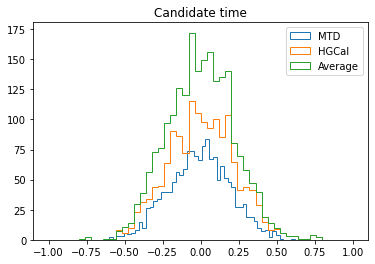

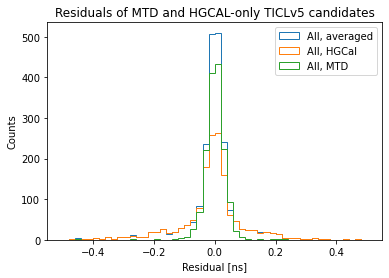

In [14]:
ticl_residuals_n_HGCal,ticl_residuals_ch_HGCal=compute_residuals(fn_resolved)
ticl_residuals_n_MTD,ticl_residuals_ch_MTD=compute_residuals_MTD(fn_resolved)
ticl_residuals_n_avg,ticl_residuals_ch_avg=compute_residuals(fn_averaged)

time_avg=readfile(fn_averaged,"candidate_time")
time_avg_err=readfile(fn_averaged,"candidate_timeErr")

time_HGCAL=f_candidates["candidate_time"].array()
time_HGCAL_err=f_candidates["candidate_timeErr"].array()
print(f_candidates["candidate_time_MTD"].array())
time_MTD=f_candidates["candidate_time_MTD"].array()
time_MTD_err=f_candidates["candidate_time_MTD_err"].array()

#time_MTD=readfile(fn_resolved,"candidate_time_MTD")

#time_MTD_err=readfile(fn_resolved,"candidate_time_MTD_err")

print(time_MTD)
print(time_MTD_err)

mask_MTD=(time_MTD_err>0)
mask_HGCal=(time_HGCAL_err!=-1)
mask_avg=(time_avg_err!=-1)

plt.title("Candidate time")
plt.hist(np.ravel(time_MTD[mask_MTD]),bins=50, histtype="step",label="MTD")
plt.hist(np.ravel(time_HGCAL[mask_HGCal]),bins=50,range=[-1,1], histtype="step",label="HGCal")

plt.hist(np.ravel(time_avg[mask_avg]),bins=50,range=[-1,1], histtype="step",label="Average")
#plt.hist(np.ravel(time_MTD_err),bins=50, histtype="step",label="Neutral")

plt.legend()

plt.show()


plt.title("Residuals of MTD and HGCAL-only TICLv5 candidates")
plt.hist(ticl_residuals_n_avg+ticl_residuals_ch_avg,bins=50, range=[-0.5,0.5],histtype="step",label="All, averaged")
plt.hist(ticl_residuals_n_HGCal+ticl_residuals_ch_HGCal,bins=50, range=[-0.5,0.5],histtype="step",label="All, HGCal")
plt.hist(ticl_residuals_n_MTD+ticl_residuals_ch_MTD,bins=50, range=[-0.5,0.5],histtype="step",label="All, MTD")

plt.legend()

plt.xlabel("Residual [ns]")
plt.ylabel("Counts")
plt.show() 










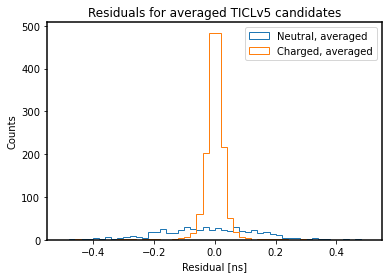

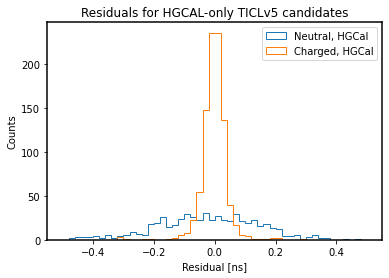

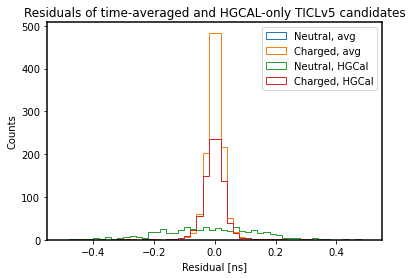

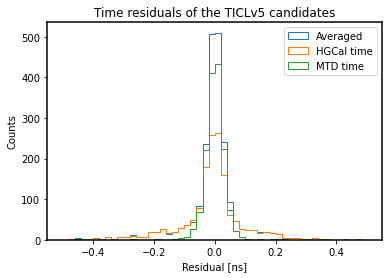

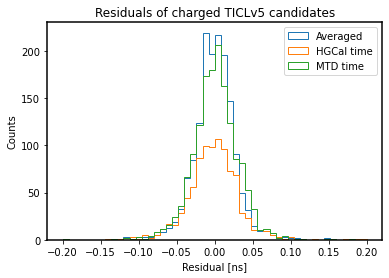

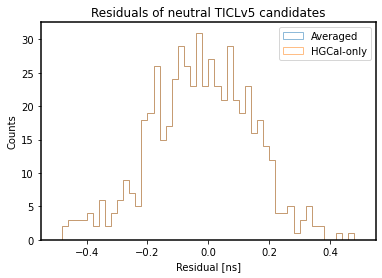

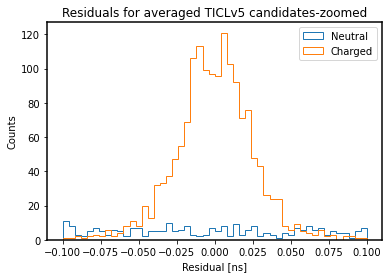

'\nplt.title("Residuals between simulated and reconstructed TICLv5 candidates")\nplt.hist(ticl_residuals_n_avg,bins=50, range=[-0.5,0.5],log=True,histtype="step",label="Neutral")\nplt.hist(ticl_residuals_ch_avg,bins=50, range=[-0.5,0.5],log=True,histtype="step",label="Charged")\nplt.legend()\nplt.xlabel("Residual [ns]")\nplt.ylabel("Counts")\nplt.show() \n'

In [22]:
#ticl_residuals_n_base,ticl_residuals_ch_base=compute_residuals("histo_average.root")
#ticl_residuals_n_HGCal,ticl_residuals_ch_HGCal=compute_residuals("histo_onlyHGCal.root")
#ticl_residuals_n_MTD,ticl_residuals_ch_MTD=compute_residuals("histo_onlyMTD_100.root")

'''
plt.title("Residuals between simulated and reconstructed TICLv5 candidates, averaged")
plt.hist(ticl_residuals_n_avg,bins=50, range=[-0.5,0.5],histtype="step",label="Neutral")
plt.hist(ticl_residuals_ch_avg,bins=50, range=[-0.5,0.5],histtype="step",label="Charged")
plt.legend()

plt.xlabel("Residual [ns]")
plt.ylabel("Counts")
plt.savefig("MTDvsHGCal/Residuals_avg.pdf")
plt.show() 
'''


plt.title("Residuals for averaged TICLv5 candidates")
plt.hist(ticl_residuals_n_avg,bins=50, range=[-0.5,0.5],histtype="step",label="Neutral, averaged")
plt.hist(ticl_residuals_ch_avg,bins=50, range=[-0.5,0.5],histtype="step",label="Charged, averaged")
plt.legend()

plt.xlabel("Residual [ns]")
plt.ylabel("Counts")

plt.savefig("MTDvsHGCal_pt_1-10/Residuals_avg.pdf")
plt.show() 



plt.title("Residuals for HGCAL-only TICLv5 candidates")
plt.hist(ticl_residuals_n_HGCal,bins=50, range=[-0.5,0.5],histtype="step",label="Neutral, HGCal")
plt.hist(ticl_residuals_ch_HGCal,bins=50, range=[-0.5,0.5],histtype="step",label="Charged, HGCal")
plt.legend()

plt.xlabel("Residual [ns]")
plt.ylabel("Counts")

plt.savefig("MTDvsHGCal_pt_1-10/Residuals_HGCAL.pdf")
plt.show() 


plt.title("Residuals of time-averaged and HGCAL-only TICLv5 candidates")
plt.hist(ticl_residuals_n_avg,bins=50, range=[-0.5,0.5],histtype="step",label="Neutral, avg")
plt.hist(ticl_residuals_ch_avg,bins=50, range=[-0.5,0.5],histtype="step",label="Charged, avg")
plt.hist(ticl_residuals_n_HGCal,bins=50, range=[-0.5,0.5],histtype="step",label="Neutral, HGCal")
plt.hist(ticl_residuals_ch_HGCal,bins=50, range=[-0.5,0.5],histtype="step",label="Charged, HGCal")
#plt.hist(ticl_residuals_n_MTD,bins=50, range=[-0.5,0.5],histtype="step",label="Neutral, MTD")
#plt.hist(ticl_residuals_ch_MTD,bins=50, range=[-0.5,0.5],histtype="step",label="Charged, MTD")

plt.legend()

plt.xlabel("Residual [ns]")
plt.ylabel("Counts")
plt.show() 

plt.title("Time residuals of the TICLv5 candidates")
plt.hist(ticl_residuals_n_avg+ticl_residuals_ch_avg,bins=50, range=[-0.5,0.5],histtype="step",label="Averaged")
plt.hist(ticl_residuals_n_HGCal+ticl_residuals_ch_HGCal,bins=50, range=[-0.5,0.5],histtype="step",label="HGCal time")
plt.hist(ticl_residuals_n_MTD+ticl_residuals_ch_MTD,bins=50, range=[-0.5,0.5],histtype="step",label="MTD time")

plt.legend()

plt.xlabel("Residual [ns]")
plt.ylabel("Counts")
plt.savefig("MTDvsHGCal_pt_1-10/Residuals_all3.pdf")

plt.show() 

plt.title("Residuals of charged TICLv5 candidates")
plt.hist(ticl_residuals_ch_avg,bins=50, range=[-0.2,0.2],histtype="step",label="Averaged")
plt.hist(ticl_residuals_ch_HGCal,bins=50, range=[-0.2,0.2],histtype="step",label="HGCal time")
plt.hist(ticl_residuals_ch_MTD,bins=50, range=[-0.2,0.2],histtype="step",label="MTD time")

plt.legend()

plt.xlabel("Residual [ns]")
plt.ylabel("Counts")

plt.savefig("MTDvsHGCal_pt_1-10/Residuals_all3_charged.pdf")
plt.show() 


plt.title("Residuals of neutral TICLv5 candidates")
plt.hist(ticl_residuals_n_avg,bins=50, range=[-0.5,0.5],histtype="step",label="Averaged",alpha=0.5)
plt.hist(ticl_residuals_n_HGCal,bins=50, range=[-0.5,0.5],histtype="step",label="HGCal-only",alpha=0.5)
#plt.hist(ticl_residuals_n_MTD,bins=50, range=[-0.5,0.5],histtype="step",label="MTD-only")

plt.legend()

plt.xlabel("Residual [ns]")
plt.ylabel("Counts")
plt.show() 


plt.title("Residuals for averaged TICLv5 candidates-zoomed")
plt.hist(ticl_residuals_n_avg,bins=50, range=[-0.1,0.1],histtype="step",label="Neutral")
plt.hist(ticl_residuals_ch_avg,bins=50, range=[-0.1,0.1],histtype="step",label="Charged")
plt.legend()
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")
plt.show() 

"""
plt.title("Residuals between simulated and reconstructed TICLv5 candidates")
plt.hist(ticl_residuals_n_avg,bins=50, range=[-0.5,0.5],log=True,histtype="step",label="Neutral")
plt.hist(ticl_residuals_ch_avg,bins=50, range=[-0.5,0.5],log=True,histtype="step",label="Charged")
plt.legend()
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")
plt.show() 
"""







In [16]:
t_res_avg,energies_avg,pt_avg,isCharged_avg=compute_residuals_energies(fn_averaged)
t_res_hgcal,energies_hgcal,pt_hgcal,isCharged_hgcal =compute_residuals_energies(fn_resolved)
t_res_mtd,energies_mtd,pt_mtd,isCharged_mtd =compute_residuals_energies_MTD(fn_resolved)
t_res_mtd_trckonly,energies_mtd_trckonly,pt_mtd_trckonly,isCharged_mtd_trckonly =compute_residuals_energies_MTD_trackonly(fn_resolved)




100%|██████████| 1000/1000 [00:01<00:00, 967.96it/s]


[[0.0276], [0.0276], [0.0276], [0.0276, ... -10, -10], [0.039, 0.039, -10, -10, -10]]
[[[]], [[]], [[]], [[0], [], [1]], [[0], ... [4], [5]], [[0], [1], [2], [3], [4]]]
[[False], [False], [False], ... False, False], [True, True, False, False, False]]


100%|██████████| 1000/1000 [00:00<00:00, 1367.37it/s]


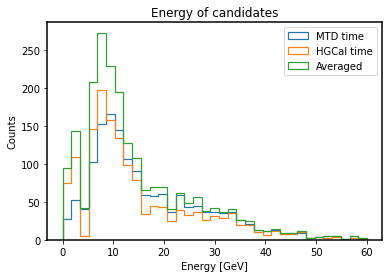

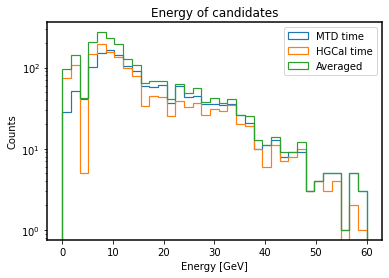

Warning in <TROOT::Append>: Replacing existing TH1: res_en_hgcal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: res_en_MTD (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: res_en_avg (Potential memory leak).
Info in <TCanvas::Print>: png file MTDvsHGCal_pt_1-10/E_res_HGCAL.png has been created
Info in <TCanvas::Print>: png file MTDvsHGCal_pt_1-10/E_res_MTD.png has been created


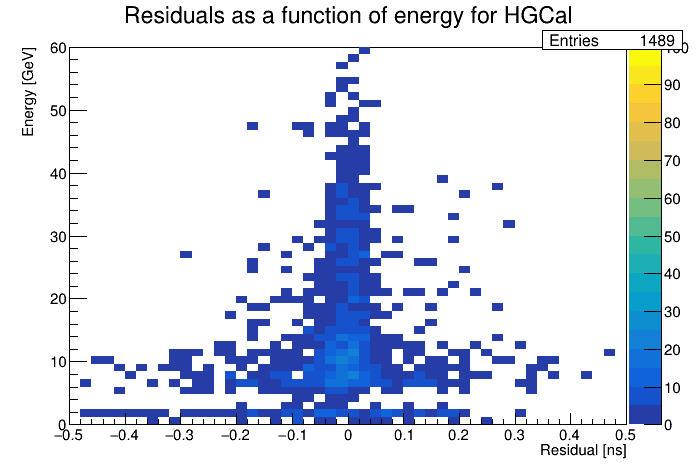

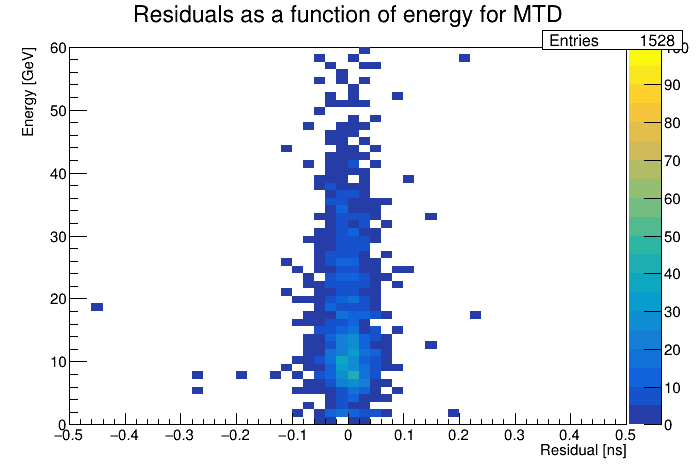

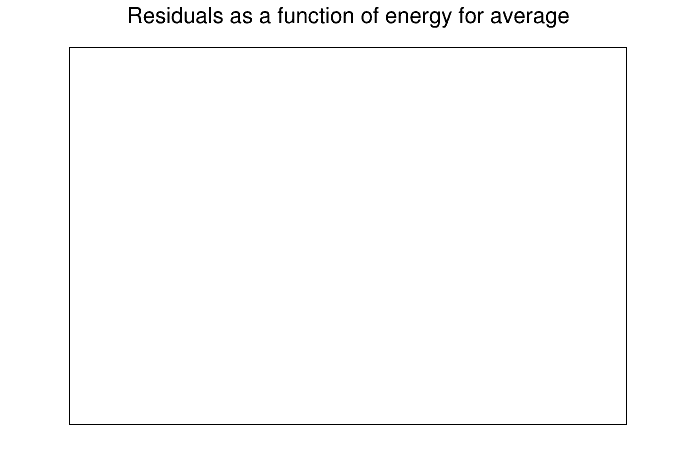

In [21]:
nbins=35
lw=1.2
plt.title("Energy of candidates")
plt.hist(energies_mtd,bins=nbins, histtype="step",label="MTD time",log=False, range=[0,60],linewidth=lw)
plt.hist(energies_hgcal,bins=nbins,histtype="step",label="HGCal time",log=False, range=[0,60],linewidth=lw)
plt.hist(energies_avg,bins=nbins,histtype="step",label="Averaged",log=False, range=[0,60],linewidth=lw)

plt.legend()
plt.xlabel("Energy [GeV]")
plt.ylabel("Counts")
plt.savefig("MTDvsHGCal_pt_1-10/Residuals_all3.pdf")
plt.show() 

plt.title("Energy of candidates")
plt.hist(energies_mtd,bins=nbins, histtype="step",label="MTD time",log=True, range=[0,60],linewidth=lw)
plt.hist(energies_hgcal,bins=nbins,histtype="step",label="HGCal time",log=True, range=[0,60],linewidth=lw)
plt.hist(energies_avg,bins=nbins,histtype="step",label="Averaged",log=True, range=[0,60],linewidth=lw)

plt.legend()
plt.xlabel("Energy [GeV]")
plt.ylabel("Counts")

plt.savefig("MTDvsHGCal_pt_1-10/Residuals_all3_log.pdf")
plt.show() 


ROOT.gStyle.SetOptStat(10)
res_en_hgcal=ROOT.TH2D("res_en_hgcal","Residuals as a function of energy for HGCal time events;Residual [ns];Energy [GeV]",50,-0.5,0.5,50,0,60)
res_en_mtd=ROOT.TH2D("res_en_MTD","Residuals as a function of energy for MTD time events;Residual [ns];Energy [GeV]",50,-0.5,0.5,50,0,60)
res_en_avg=ROOT.TH2D("res_en_avg","Residuals as a function of energy for time averaged events;Residual [ns];Energy [GeV]",50,-0.5,0.5,50,0,60)


for i in range(len(t_res_hgcal)):
    res_en_hgcal.Fill(t_res_hgcal[i],energies_hgcal[i])

for i in range(len(t_res_mtd)):
    res_en_mtd.Fill(t_res_mtd[i],energies_mtd[i])
for i in range(len(t_res_avg)):
    res_en_avg.Fill(t_res_avg[i],energies_avg[i])

c1=ROOT.TCanvas()
c1.cd()

res_en_hgcal.GetZaxis().SetRangeUser(0,100)
res_en_hgcal.Draw("COLZ")

c1.SaveAs("MTDvsHGCal_pt_1-10/E_res_HGCAL.png")
c1.Draw()



c2=ROOT.TCanvas()
c2.cd()
res_en_mtd.GetZaxis().SetRangeUser(0,100)
res_en_mtd.Draw("COLZ")
c2.SaveAs("MTDvsHGCal_pt_1-10/E_res_MTD.png")

c2.Draw()


c3=ROOT.TCanvas()
c3.cd()
res_en_avg.GetZaxis().SetRangeUser(0,100)
res_en_avg.Draw("COLZ")
c3.Draw()

# Per carichi

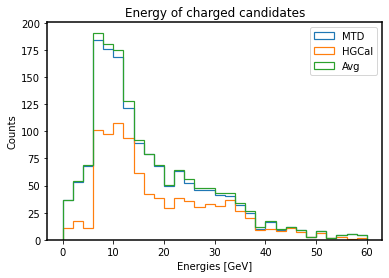

[ 37.  54.  69. 191. 181. 175. 128.  92.  79.  69.  51.  64.  56.  48.
  48.  43.  43.  34.  27.  12.  17.  10.  12.   9.   3.   8.   2.   4.
   5.   4.] [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60.]


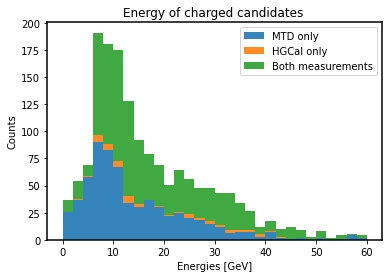

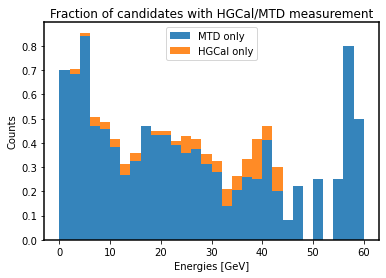

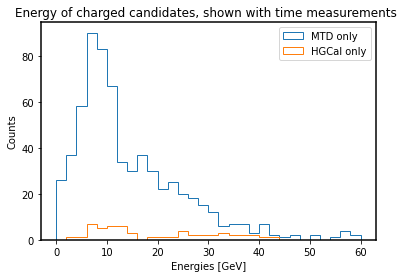

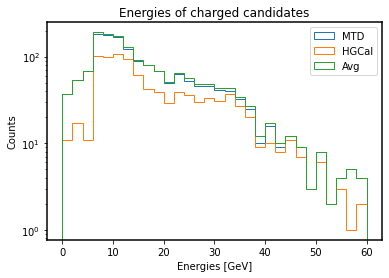

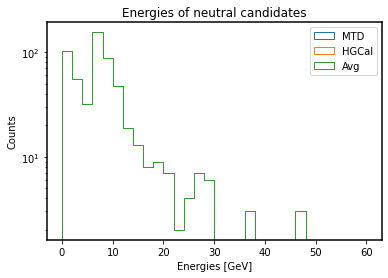

Warning in <TROOT::Append>: Replacing existing TH1: res_en_hgcal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: res_en_MTD (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: res_en_avg (Potential memory leak).
Info in <TCanvas::Print>: png file MTDvsHGCal_pt_1-10/E_res_HGCAL_charged.png has been created
Info in <TCanvas::Print>: png file MTDvsHGCal_pt_1-10/E_res_MTD_charged.png has been created


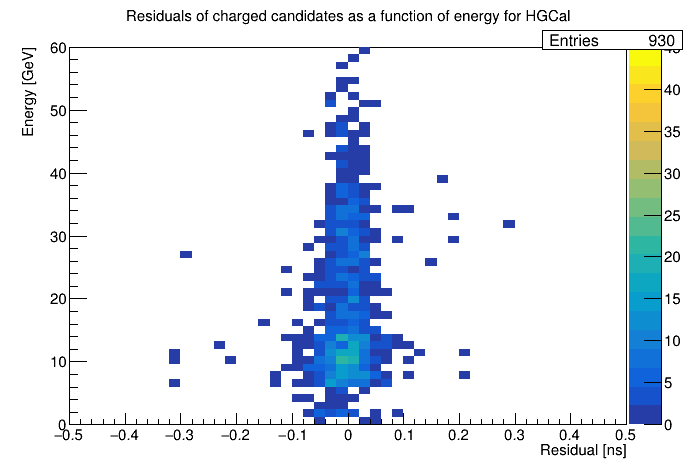

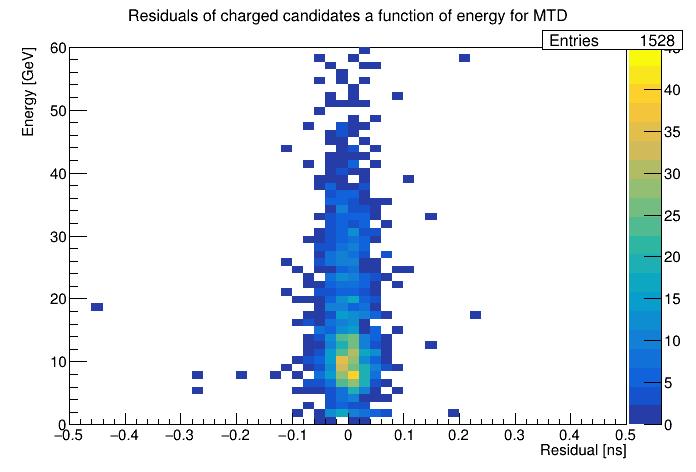

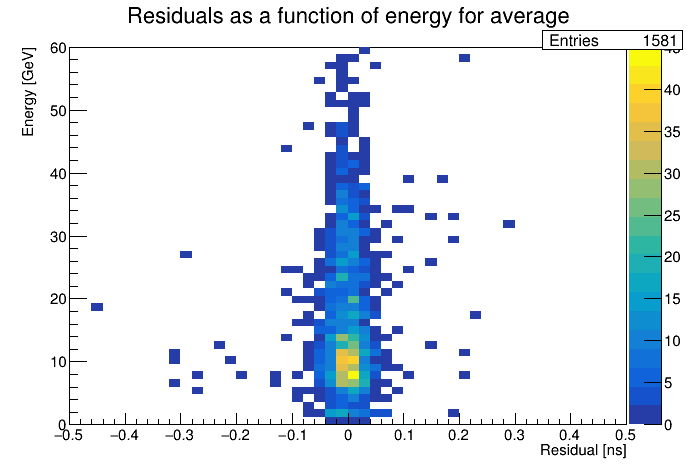

In [39]:
nbins=30
lw=1.2


plt.title("Energy of charged candidates")


c_en_mtd,bin_limits,_  = plt.hist(np.array(energies_mtd)[np.array(isCharged_mtd)], bins=nbins, histtype="step",label="MTD",log=False, range=[0,60],linewidth=1.2)
c_en_hgcal,bin_limits,_  = plt.hist(np.array(energies_hgcal)[isCharged_hgcal],bins=nbins,histtype="step",label="HGCal",log=False, range=[0,60],linewidth=1.2)
c_en_avg,bin_limits,_  = plt.hist(np.array(energies_avg)[isCharged_avg],bins=nbins,histtype="step",label="Avg",log=False, range=[0,60],linewidth=1.2)

plt.legend()
plt.xlabel("Energies [GeV]")
plt.ylabel("Counts")

plt.savefig("MTDvsHGCal_pt_1-10/En_3_charged.pdf")
plt.show() 


print(c_en_avg,bin_limits)

count_mtd_only=np.array(c_en_avg)-np.array(c_en_hgcal)
count_hgcal_only=np.array(c_en_avg)-np.array(c_en_mtd)
count_both=np.array(c_en_avg) - count_mtd_only - count_hgcal_only



plt.title("Energy of charged candidates ")
plt.hist([np.linspace(0,60,nbins),np.linspace(0,60,nbins),np.linspace(0,60,nbins)], 
         weights=[np.array(count_mtd_only),np.array(count_hgcal_only),np.array(count_both)],
         bins=nbins,histtype="bar",label=["MTD only","HGCal only","Both measurements"],log=False, range=[0,60],stacked=True,alpha=0.9,linewidth=1.2)
#plt.hist(np.linspace(0,600,50), weights=np.array(count_hgcal_only),bins=50,histtype="step",label="HGCal only",log=False, range=[0,600],stacked=True)


plt.legend()
plt.xlabel("Energies [GeV]")
plt.ylabel("Counts")

plt.savefig("MTDvsHGCal_pt_1-10/En_3_charged_stacked.pdf")

plt.show() 



plt.title("Fraction of candidates with HGCal/MTD measurement")
plt.hist([np.linspace(0,60,nbins),np.linspace(0,60,nbins)], 
         weights=[np.array(count_mtd_only)/(np.array(c_en_avg)),np.array(count_hgcal_only)/np.array(c_en_avg)],
         bins=nbins,histtype="bar",label=["MTD only","HGCal only"],log=False, range=[0,60],stacked=True,alpha=0.9)




plt.legend()
plt.xlabel("Energies [GeV]")
plt.ylabel("Counts")

plt.show() 


plt.title("Energy of charged candidates, shown with time measurements ")

plt.hist(np.linspace(0,60,nbins), weights=np.array(count_mtd_only),bins=nbins,histtype="step",label="MTD only",log=False, range=[0,60])
plt.hist(np.linspace(0,60,nbins), weights=np.array(count_hgcal_only),bins=nbins,histtype="step",label="HGCal only",log=False, range=[0,60])


plt.legend()
plt.xlabel("Energies [GeV]")
plt.ylabel("Counts")
plt.show() 




plt.title("Energies of charged candidates")
plt.hist(np.array(energies_mtd)[np.array(isCharged_mtd)], bins=nbins, histtype="step",label="MTD",log=True, range=[0,60])
plt.hist(np.array(energies_hgcal)[isCharged_hgcal],bins=nbins,histtype="step",label="HGCal",log=True, range=[0,60])
plt.hist(np.array(energies_avg)[isCharged_avg],bins=nbins,histtype="step",label="Avg",log=True, range=[0,60])

plt.legend()
plt.xlabel("Energies [GeV]")
plt.ylabel("Counts")
plt.show() 


plt.title("Energies of neutral candidates")
plt.hist(np.array(energies_mtd)[~np.array(isCharged_mtd)], bins=nbins, histtype="step",label="MTD",log=True, range=[0,60])
plt.hist(np.array(energies_hgcal)[~np.array(isCharged_hgcal)],bins=nbins,histtype="step",label="HGCal",log=True, range=[0,60])
plt.hist(np.array(energies_avg)[~np.array(isCharged_avg)],bins=nbins,histtype="step",label="Avg",log=True, range=[0,60])

plt.legend()
plt.xlabel("Energies [GeV]")
plt.ylabel("Counts")
plt.show() 


ROOT.gStyle.SetOptStat(10)
res_en_hgcal=ROOT.TH2D("res_en_hgcal","Residuals of charged candidates as a function of energy for HGCal;Residual [ns];Energy [GeV]",50,-0.5,0.5,50,0,60)
res_en_mtd=ROOT.TH2D("res_en_MTD","Residuals of charged candidates a function of energy for MTD;Residual [ns];Energy [GeV]",50,-0.5,0.5,50,0,60)
res_en_avg=ROOT.TH2D("res_en_avg","Residuals as a function of energy for average;Residual [ns];Energy [GeV]",50,-0.5,0.5,50,0,60)


for i in range(len(t_res_hgcal)):
    if(isCharged_hgcal[i]):
        res_en_hgcal.Fill(t_res_hgcal[i],energies_hgcal[i])

for i in range(len(t_res_mtd)):
    if(isCharged_mtd[i]):
        res_en_mtd.Fill(t_res_mtd[i],energies_mtd[i])
for i in range(len(t_res_avg)):
    if(isCharged_avg[i]):
        res_en_avg.Fill(t_res_avg[i],energies_avg[i])

c1=ROOT.TCanvas()
c1.cd()

res_en_hgcal.GetZaxis().SetRangeUser(0,45)
res_en_hgcal.Draw("COLZ")
c1.SaveAs("MTDvsHGCal_pt_1-10/E_res_HGCAL_charged.png")

c1.Draw()



c2=ROOT.TCanvas()
c2.cd()
res_en_mtd.GetZaxis().SetRangeUser(0,45)

res_en_mtd.Draw("COLZ")

c2.SaveAs("MTDvsHGCal_pt_1-10/E_res_MTD_charged.png")
c2.Draw()


c3=ROOT.TCanvas()
c3.cd()
res_en_avg.GetZaxis().SetRangeUser(0,45)
res_en_avg.Draw("COLZ")
c3.Draw()

# Linked with tracksters only

[[0.0276], [0.0276], [0.0276], [0.0276, ... -10, -10], [0.039, 0.039, -10, -10, -10]]
[[[]], [[]], [[]], [[0], [], [1]], [[0], ... [4], [5]], [[0], [1], [2], [3], [4]]]
[[False], [False], [False], ... False, False], [True, True, False, False, False]]


100%|██████████| 1000/1000 [00:00<00:00, 1214.46it/s]


[[0.0276], [0.0276], [0.0276], [0.0162, ... -1, -1], [0.0178, 0.0178, -1, -1, -1]]
[[[]], [[]], [[]], [[0], [1]], [[0], [], ... [4], [5]], [[0], [1], [2], [3], [4]]]
[[False], [False], [False], ... False, False], [True, True, False, False, False]]


100%|██████████| 1000/1000 [00:01<00:00, 784.00it/s]


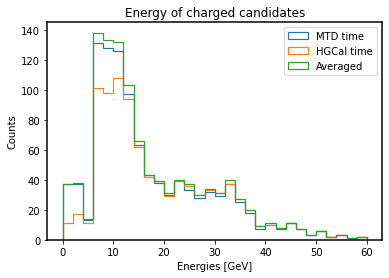

[ 37.  38.  14. 138. 133. 132. 103.  66.  43.  39.  31.  40.  37.  30.
  34.  31.  40.  27.  20.   9.  11.   8.  11.   7.   3.   6.   2.   3.
   1.   2.] [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60.]


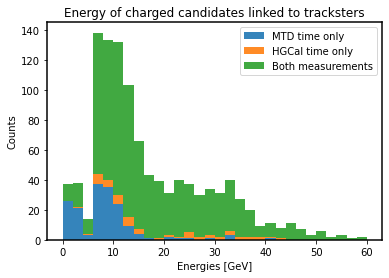

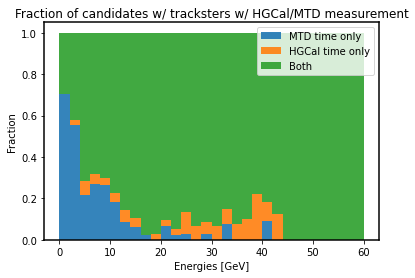

In [37]:
t_res_mtd_trckonly,energies_mtd_trckonly,pt_mtd_trckonly,isCharged_mtd_trckonly=compute_residuals_energies_MTD_trackonly(fn_resolved)
t_res_avg_trckonly,energies_avg_trckonly,pt_avg_trckonly,isCharged_avg_trckonly=compute_residuals_energies_trackonly(fn_averaged)


nbins=30

plt.title("Energy of charged candidates")
c_en_mtd,bin_limits,_  = plt.hist(np.array(energies_mtd_trckonly)[np.array(isCharged_mtd_trckonly)], bins=nbins, histtype="step",label="MTD time ",log=False, range=[0,60],linewidth=1.2)
c_en_hgcal,bin_limits,_  = plt.hist(np.array(energies_hgcal)[isCharged_hgcal],bins=nbins,histtype="step",label="HGCal time",log=False, range=[0,60],linewidth=1.2)
c_en_avg,bin_limits,_  = plt.hist(np.array(energies_avg_trckonly)[isCharged_avg_trckonly],bins=nbins,histtype="step",label="Averaged",log=False, range=[0,60],linewidth=1.2)

plt.legend()
plt.xlabel("Energies [GeV]")
plt.ylabel("Counts")
plt.savefig("MTDvsHGCal_pt_1-10/En_3_charged.pdf")
plt.show() 

print(c_en_avg,bin_limits)

count_mtd_only=np.array(c_en_avg)-np.array(c_en_hgcal)
count_hgcal_only=np.array(c_en_avg)-np.array(c_en_mtd)
count_both=np.array(c_en_avg) - count_mtd_only - count_hgcal_only





plt.title("Energy of charged candidates linked to tracksters")
plt.hist([np.linspace(0,60,nbins),np.linspace(0,60,nbins),np.linspace(0,60,nbins)], 
         weights=[np.array(count_mtd_only),np.array(count_hgcal_only),np.array(count_both)],
         bins=nbins,histtype="bar",label=["MTD time only","HGCal time only","Both measurements"],log=False, range=[0,60],stacked=True,alpha=0.9)
#plt.hist(np.linspace(0,600,50), weights=np.array(count_hgcal_only),bins=50,histtype="step",label="HGCal only",log=False, range=[0,600],stacked=True)


plt.legend()
plt.xlabel("Energies [GeV]")
plt.ylabel("Counts")

plt.savefig("MTDvsHGCal_pt_1-10/En_3_charged_tracksters_stacked.pdf")
plt.show() 



plt.title("Fraction of candidates w/ tracksters w/ HGCal/MTD measurement")
plt.hist([np.linspace(0,60,nbins),np.linspace(0,60,nbins),np.linspace(0,60,nbins)], 
         weights=[np.array(count_mtd_only)/(np.array(c_en_avg)),np.array(count_hgcal_only)/np.array(c_en_avg),
         np.ones(count_mtd_only.shape)-np.array(count_hgcal_only)/np.array(c_en_avg)-np.array(count_mtd_only)/(np.array(c_en_avg))],
         bins=nbins,histtype="bar",label=["MTD time only","HGCal time only","Both"],log=False, range=[0,60],stacked=True,alpha=0.9)




plt.legend()
plt.xlabel("Energies [GeV]")
plt.ylabel("Fraction")

plt.savefig("MTDvsHGCal_pt_1-10/En_3_charged_trackstes_fraction.pdf")
plt.show() 




# Neutri

In [ ]:
plt.title("Energies of candidates")
c_en_mtd,bin_limits,_ = plt.hist(energies_mtd,bins=50, histtype="step",label="MTD",log=False, range=[0,600])
c_en_hgcal,bin_limits,_ = plt.hist(energies_hgcal,bins=50,histtype="step",label="HGCal",log=False, range=[0,600])
c_en_avg,bin_limits,_ = plt.hist(energies_avg,bins=50,histtype="step",label="Avg",log=False, range=[0,600])




plt.title("Energies of candidates")
plt.hist(energies_mtd,bins=50, histtype="step",label="MTD",log=True, range=[0,600])
plt.hist(energies_hgcal,bins=50,histtype="step",label="HGCal",log=True, range=[0,600])
plt.hist(energies_avg,bins=50,histtype="step",label="Avg",log=True, range=[0,600])

plt.legend()
plt.xlabel("Energies [GeV]")
plt.ylabel("Counts")
plt.show() 


ROOT.gStyle.SetOptStat(10)
res_en_hgcal=ROOT.TH2D("res_en_hgcal","Residuals as a function of energy for HGCal;Residual [ns];Energy [GeV]",50,-0.5,0.5,50,0,600)
res_en_mtd=ROOT.TH2D("res_en_MTD","Residuals as a function of energy for MTD;Residual [ns];Energy [GeV]",50,-0.5,0.5,50,0,600)
res_en_avg=ROOT.TH2D("res_en_avg","Residuals as a function of energy for average;Residual [ns];Energy [GeV]",50,-0.5,0.5,50,0,600)


for i in range(len(t_res_hgcal)):
    if(not isCharged_hgcal[i]):
        
        res_en_hgcal.Fill(t_res_hgcal[i],energies_hgcal[i])

for i in range(len(t_res_mtd)):
    if(not isCharged_mtd[i]):
        res_en_mtd.Fill(t_res_mtd[i],energies_mtd[i])
for i in range(len(t_res_avg)):
    if(not isCharged_avg[i]):
        res_en_avg.Fill(t_res_avg[i],energies_avg[i])

c1=ROOT.TCanvas()
c1.cd()

#res_en_hgcal.GetZaxis().SetRangeUser(0,100)
res_en_hgcal.Draw("COLZ")
c1.Draw()



c2=ROOT.TCanvas()
c2.cd()
#res_en_mtd.GetZaxis().SetRangeUser(0,100)
res_en_mtd.Draw("COLZ")
c2.Draw()


c3=ROOT.TCanvas()
c3.cd()
#res_en_avg.GetZaxis().SetRangeUser(0,100)
res_en_avg.Draw("COLZ")
c3.Draw()

# pT

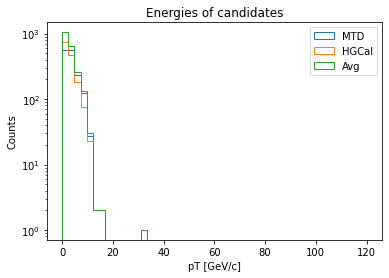

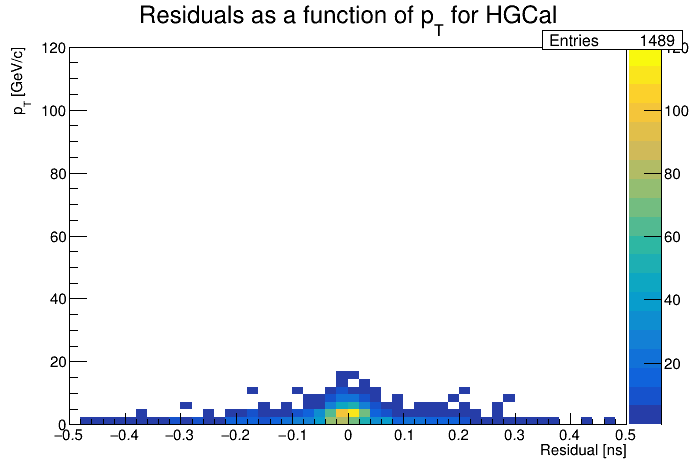

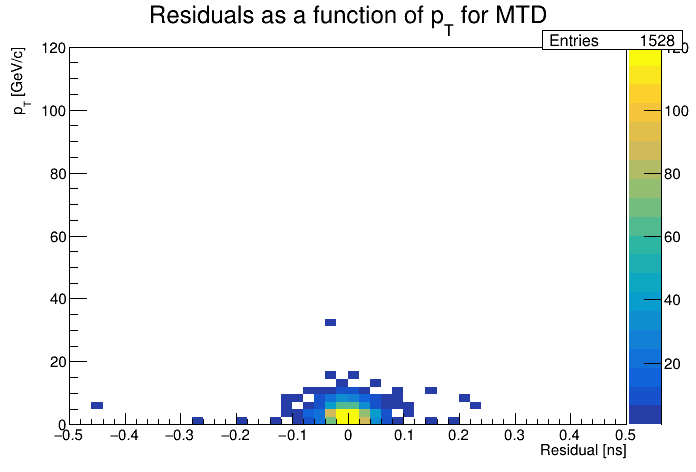

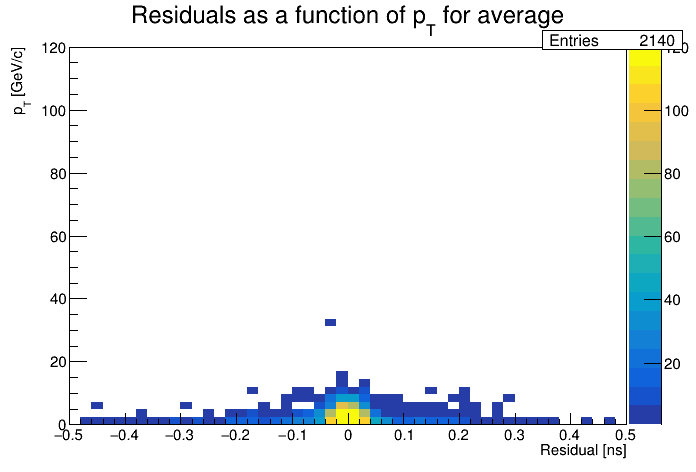

In [67]:
plt.title("Energies of candidates")
plt.hist(pt_mtd,bins=50, histtype="step",label="MTD",log=True, range=[0,120])
plt.hist(pt_hgcal,bins=50,histtype="step",label="HGCal",log=True, range=[0,120])
plt.hist(pt_avg,bins=50,histtype="step",label="Avg",log=True, range=[0,120])

plt.legend()
plt.xlabel("pT [GeV/c]")
plt.ylabel("Counts")
plt.show() 



res_pt_hgcal=ROOT.TH2D("res_pt_hgcal","Residuals as a function of p_{T} for HGCal;Residual [ns];p_{T} [GeV/c]",50,-0.5,0.5,50,0,120)
res_pt_mtd=ROOT.TH2D("res_pt_MTD","Residuals as a function of p_{T} for MTD;Residual [ns];p_{T} [GeV/c]",50,-0.5,0.5,50,0,120)
res_pt_avg=ROOT.TH2D("res_pt_avg","Residuals as a function of p_{T} for average;Residual [ns];p_{T} [GeV/c]",50,-0.5,0.5,50,0,120)


res_pt_hgcal.GetZaxis().SetRangeUser(0.5,120)
res_pt_mtd.GetZaxis().SetRangeUser(0.5,120)
res_pt_avg.GetZaxis().SetRangeUser(0.5,120)

for i in range(len(t_res_hgcal)):
    res_pt_hgcal.Fill(t_res_hgcal[i],pt_hgcal[i])

for i in range(len(t_res_mtd)):
    res_pt_mtd.Fill(t_res_mtd[i],pt_mtd[i])
for i in range(len(t_res_avg)):
    res_pt_avg.Fill(t_res_avg[i],pt_avg[i])

c1=ROOT.TCanvas()
c1.cd()
res_pt_hgcal.Draw("COLZ")
c1.Draw()



c2=ROOT.TCanvas()
c2.cd()
#c2.SetLogz()
res_pt_mtd.Draw("COLZ")
c2.Draw()


c3=ROOT.TCanvas()
c3.cd()
res_pt_avg.Draw("COLZ")
c3.Draw()